In [1]:
# import libraries
from math import sin, cos, sqrt, atan2, radians
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine, correlation
import os
import geopandas as gpd
import shapely 
import plotly.express as px
import glob
import seaborn as sns
from geopandas.tools import sjoin
from mpl_toolkits.axes_grid1 import make_axes_locatable
 
# to ignore the warnings 
from warnings import filterwarnings

# Read CSV Files and look at how the data looks like

In [100]:
# Read multiple CSV files and merge into one dataframe (Mo 30 December 2019 | Su 02 februari 2020)
path = r'Snuffelfiets_data' # use your path
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0, low_memory=False)
    li.append(df)

snuffelfiets_df = pd.concat(li, axis=0, ignore_index=True)

# Exploratory Analysis  

First some exploratory analysis is done on the data. It is needed to know what data is available and what the corresponding statistics are for different values (min, max) to detect anomalies and outliers. 

In [3]:
# Have a look at what the content is of the data
snuffelfiets_df.head(5)

,sensor,air_quality_observed_id,lon,lat,recording_time,trip_sequence,humidity,pm10,pm1_0,pm2_5,pressure,temperature,voc,voltage,error_code,version_major,version_minor,acc_max,no2
0,a3395e4aa87ff154f320ecea0e576e40,11054993,5.352763,52.056545,2020-01-13 11:59:36,16,72,11,8,9,1014,10.1,42,3.99,0,1,6,2,0
1,9a462bb6403b7ce1be47920afaa27015,11054885,5.265505,51.356956,2020-01-13 11:59:30,9,70,12,11,12,1015,10.0,59,3.96,0,1,6,0,0
2,a3395e4aa87ff154f320ecea0e576e40,11054992,5.352232,52.055267,2020-01-13 11:59:22,16,71,10,7,8,1014,10.1,41,3.99,0,1,6,0,0
3,9a462bb6403b7ce1be47920afaa27015,11054884,5.266115,51.356220,2020-01-13 11:59:16,9,69,12,11,12,1015,10.0,59,3.97,0,1,6,0,0
4,5d47cba21e430ba29d99613b9b72fdd2,11054856,5.094020,51.989609,2020-01-13 11:59:11,17,46,9,8,8,998,15.8,111,3.73,0,1,6,0,0


In [4]:
# Find out what type of data is present
snuffelfiets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1112961 entries, 0 to 1112960
Data columns (total 19 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   sensor                   1112961 non-null  object 
 1   air_quality_observed_id  1112961 non-null  int64  
 2   lon                      1112961 non-null  float64
 3   lat                      1112961 non-null  float64
 4   recording_time           1112961 non-null  object 
 5   trip_sequence            1112961 non-null  int64  
 6   humidity                 1112961 non-null  int64  
 7   pm10                     1112961 non-null  int64  
 8   pm1_0                    1112961 non-null  int64  
 9   pm2_5                    1112961 non-null  int64  
 10  pressure                 1112961 non-null  int64  
 11  temperature              1112961 non-null  float64
 12  voc                      1112961 non-null  int64  
 13  voltage                  1112961 non-null 

In [5]:
# Delete columns that are not of interest
snuffelfiets_df = snuffelfiets_df.drop(columns=['voc', 'version_major', 'version_minor', 'acc_max', 'voc', 'pm10', 'pm1_0', 'no2'])

# Get some statistics for the different variables
snuffelfiets_df.describe()

,air_quality_observed_id,lon,lat,trip_sequence,humidity,pm2_5,pressure,temperature,voltage,error_code
count,1.112961e+06,1.112961e+06,1.112961e+06,1.112961e+06,1.112961e+06,1.112961e+06,1.112961e+06,1.112961e+06,1.112961e+06,1.112961e+06
mean,1.959071e+07,5.269125e+00,5.201946e+01,8.061078e+00,6.923571e+01,1.067867e+01,1.774846e+04,1.165633e+01,3.891840e+00,2.595435e+02
std,6.552194e+06,3.963633e-01,3.234918e-01,6.801365e+00,1.324894e+01,2.342639e+01,8.479463e+05,5.461064e+01,1.352644e-01,6.779037e+02
min,1.598470e+06,4.306155e+00,5.084615e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,0.000000e+00
25%,1.116469e+07,5.091514e+00,5.202928e+01,3.000000e+00,6.000000e+01,3.000000e+00,9.920000e+02,8.200000e+00,3.760000e+00,0.000000e+00
50%,2.309916e+07,5.164830e+00,5.207966e+01,7.000000e+00,7.100000e+01,7.000000e+00,1.006000e+03,1.080000e+01,3.880000e+00,0.000000e+00
75%,2.374924e+07,5.388180e+00,5.210379e+01,1.200000e+01,8.000000e+01,1.400000e+01,1.020000e+03,1.330000e+01,4.010000e+00,0.000000e+00
max,2.451523e+07,1.322950e+01,5.592898e+01,4.200000e+01,1.000000e+02,5.630000e+03,4.294950e+07,6.553500e+03,5.550000e+00,2.720000e+03


# Data Cleaning

Before the data can be used for analysis, the data needs to be cleaned from incorrect observations:  

step 1) Delete pm2_5 values < 0.5 and > 150 ug/m3  
step 2) Delete sensor speeds > 45 km/h and < 5 km/h  
step 3) Delete observations outside of Utrecht  
step 4) Analyze the data for further cleaning

## 1) Delete PM2_5 values < 0.5 and > 150 ug/m3

In [101]:
# Delete the observations where pm2_5 < 0,5 and > 150 ug/m3.
smaller_selection = snuffelfiets_df[snuffelfiets_df['pm2_5'] >= 0.5].reset_index(drop=True)

#this are only around 2000 observations (<0.2 % of the dataset, therefore they are not imputed as suggested)
smaller_selection = smaller_selection[smaller_selection['pm2_5'] <= 150].reset_index(drop=True) 
smaller_selection.describe()

,air_quality_observed_id,lon,lat,trip_sequence,humidity,pm10,pm1_0,pm2_5,pressure,temperature,voc,voltage,error_code,version_major,version_minor,acc_max,no2
count,1.060428e+06,1.060428e+06,1.060428e+06,1.060428e+06,1.060428e+06,1.060428e+06,1.060428e+06,1.060428e+06,1.060428e+06,1.060428e+06,1.060428e+06,1.060428e+06,1.060428e+06,1060428.0,1.060428e+06,1.060428e+06,1.060428e+06
mean,1.961798e+07,5.265297e+00,5.202215e+01,8.085307e+00,6.947027e+01,1.304265e+01,8.790451e+00,1.100594e+01,1.849880e+04,1.158568e+01,9.294980e+01,3.891042e+00,2.279495e+02,1.0,5.812384e+00,1.057309e-01,3.457370e+00
std,6.550732e+06,3.754985e-01,3.114941e-01,6.804878e+00,1.284515e+01,1.399284e+01,8.003401e+00,1.086330e+01,8.666843e+05,5.554441e+01,6.325251e+01,1.347136e-01,6.427823e+02,0.0,4.805811e-01,5.611755e-01,5.882365e+01
min,1.598470e+06,4.306155e+00,5.084661e+01,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,3.560000e+02,0.000000e+00,0.000000e+00,3.000000e+00,0.000000e+00,1.0,3.000000e+00,0.000000e+00,0.000000e+00
25%,1.116950e+07,5.091056e+00,5.202934e+01,3.000000e+00,6.000000e+01,4.000000e+00,3.000000e+00,4.000000e+00,9.910000e+02,8.100000e+00,4.200000e+01,3.760000e+00,0.000000e+00,1.0,6.000000e+00,0.000000e+00,0.000000e+00
50%,2.310588e+07,5.163769e+00,5.207941e+01,7.000000e+00,7.100000e+01,8.000000e+00,6.000000e+00,7.000000e+00,1.006000e+03,1.070000e+01,8.100000e+01,3.880000e+00,0.000000e+00,1.0,6.000000e+00,0.000000e+00,0.000000e+00
75%,2.374300e+07,5.387012e+00,5.210327e+01,1.200000e+01,8.000000e+01,1.600000e+01,1.200000e+01,1.400000e+01,1.020000e+03,1.320000e+01,1.310000e+02,4.010000e+00,0.000000e+00,1.0,6.000000e+00,0.000000e+00,0.000000e+00
max,2.451523e+07,1.322950e+01,5.583738e+01,4.200000e+01,1.000000e+02,2.570000e+02,1.340000e+02,1.500000e+02,4.294950e+07,6.553500e+03,5.270000e+02,5.550000e+00,2.592000e+03,1.0,6.000000e+00,7.500000e+01,2.563000e+03


## 2) Delete incorrect observations with high speeds
Next step is to filter the measurements that are registred at high speeds > 45 km/h (e.g. car or train). For this the speed is calculated based on the x,y coordinates and time stamps. 

Step 1) The distance between two consequtive points is calculated using geopandas (Haversine formula)  
Step 2) The time difference between two consequtive points is calculated  
step 3) Speed is calculated as distance/time.   
step 4) Add column speed to dataframe and iterate over all rows


In [102]:
# Sort dataframe on sensor ID and the measurement times
sort_values = smaller_selection.sort_values(['sensor', 'air_quality_observed_id', 'recording_time'], ascending=True).reset_index(drop=True)

# Convert the 'Date' column to datetime format
sort_values['recording_time'] = pd.to_datetime(sort_values['recording_time'])

# Transform dataframe to GeoDataFrame to calculate distance
geo_df = gpd.GeoDataFrame(sort_values, geometry = gpd.points_from_xy(sort_values['lon'], sort_values['lat'], crs="EPSG:4326"))

# Reproject to CRS Amersfoort NEW
geo_df = geo_df.to_crs("EPSG:28992")

# Add column distance
geo_df['distance'] = geo_df.distance(geo_df.shift(1))

# Add column timedifference
geo_df['delta_time'] = geo_df['recording_time'] - geo_df['recording_time'].shift(1)

# Convert to seconds
geo_df['delta_time'] = geo_df['delta_time'].dt.seconds

# Add column speed and convert to km/h
geo_df['speed'] = geo_df['distance'] / geo_df['delta_time']
geo_df['speed'] = round(geo_df['speed'] * 3.6, 1)

geo_df = geo_df[geo_df['speed'] < 45]
geo_df = geo_df[geo_df['speed'] > 5]
geo_df = geo_df.reset_index(drop=True)

# Have a look at the new statistics
geo_df.describe()

<ipython-input-102-2b22e33de63a>:14: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:28992
Right CRS: None

  geo_df['distance'] = geo_df.distance(geo_df.shift(1))


,air_quality_observed_id,lon,lat,trip_sequence,humidity,pm10,pm1_0,pm2_5,pressure,temperature,voc,voltage,error_code,version_major,version_minor,acc_max,no2,distance,delta_time,speed
count,7.054920e+05,705492.000000,705492.000000,705492.000000,705492.000000,705492.000000,705492.000000,705492.000000,7.054920e+05,705492.000000,705492.000000,705492.000000,705492.000000,705492.0,705492.000000,705492.000000,705492.000000,705492.000000,705492.000000,705492.000000
mean,1.951380e+07,5.264379,52.024286,7.950121,69.526834,12.760724,8.591100,10.769755,2.145634e+04,11.562026,91.511218,3.894253,231.168807,1.0,5.832704,0.128601,3.531178,128.195755,28.136561,18.440786
std,6.707104e+06,0.364402,0.305571,6.772301,12.926884,13.307788,7.531451,10.294879,9.370622e+05,60.365892,61.092152,0.135247,646.974017,0.0,0.437638,0.608490,56.670347,1904.134496,570.009665,5.718797
min,1.598489e+06,4.306330,50.846634,0.000000,0.000000,1.000000,0.000000,1.000000,3.560000e+02,0.000000,0.000000,3.000000,0.000000,1.0,3.000000,0.000000,0.000000,15.432917,8.000000,5.100000
25%,1.116540e+07,5.090566,52.030346,3.000000,60.000000,4.000000,3.000000,4.000000,9.910000e+02,8.000000,42.000000,3.760000,0.000000,1.0,6.000000,0.000000,0.000000,60.242503,13.000000,14.900000
50%,2.310675e+07,5.160864,52.078262,6.000000,71.000000,8.000000,6.000000,7.000000,1.005000e+03,10.600000,80.000000,3.880000,0.000000,1.0,6.000000,0.000000,0.000000,78.758640,14.000000,18.200000
75%,2.374297e+07,5.390955,52.105782,12.000000,80.000000,16.000000,12.000000,14.000000,1.020000e+03,13.100000,130.000000,4.010000,0.000000,1.0,6.000000,0.000000,0.000000,119.792097,26.000000,22.000000
max,2.451523e+07,13.229502,55.735847,42.000000,100.000000,218.000000,127.000000,150.000000,4.294950e+07,6553.500000,527.000000,5.550000,2592.000000,1.0,6.000000,70.000000,2540.000000,714559.647146,85886.000000,44.900000


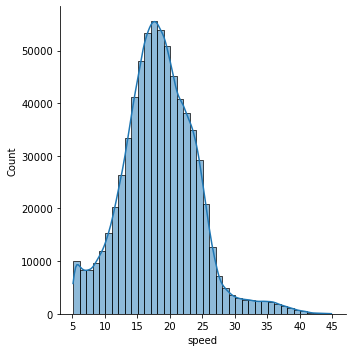

In [170]:
# plot the distribution of the speeds
sns.displot(geo_df, x='speed', binwidth=1, kde=True)

The distribution plot shows that most of the measurements are done between 9 - 27 km/h with some outliers that are faster (e.g. electrical bikes, race bikes). 

##  3) Remove observations outside Utrecht  

a) Remove observations outside boundary

In [171]:
# Retrieve data with municipal boundaries from PDOK
geodata_url = 'https://geodata.nationaalgeoregister.nl/cbsgebiedsindelingen/wfs?request=GetFeature&service=WFS&version=2.0.0&typeName=cbs_gemeente_2017_gegeneraliseerd&outputFormat=json'
municipal_boundaries = gpd.read_file(geodata_url)

# Get the geometry of Utrecht
Utrechtgeo = municipal_boundaries[municipal_boundaries['statnaam'] == 'Utrecht']

# Transform to right CRS
Utrechtgeo = Utrechtgeo.to_crs("EPSG:28992").reset_index(drop=True)

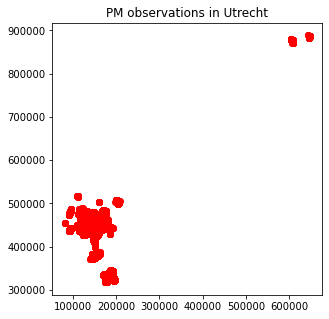

In [172]:
# Plot Utrecht
ax = Utrechtgeo.plot(figsize=(10, 5), color='white', edgecolor='black')

# Plot the Geodataframe.
geo_df.plot(ax=ax, color='red')
ax.set_title('PM observations in Utrecht')
plt.show()

### 1a) Remove measurements outside Utrecht  

From the plot can be seen that a lot of points are outside of Utrecht. These observations need to be removed from the dataset

In [173]:
# Remove all measurements outside of Utrecht Province by performing an inner join
geo_df = gpd.sjoin(geo_df, Utrechtgeo, how="inner", op='within')

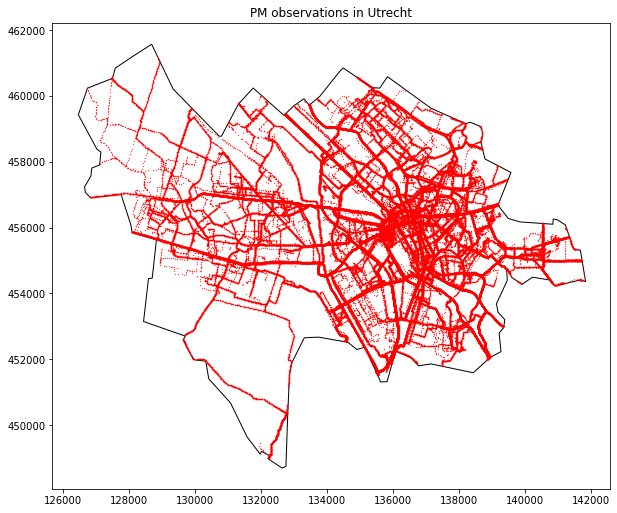

In [174]:
# Plot the observations within Utrecht
ax = Utrechtgeo.plot(figsize=(10, 10), color='white', edgecolor='black')

# Plot the new Geodataframe without the observations outside of Utrecht
geo_df.plot(ax=ax, color='red', markersize = 0.1)
ax.set_title('PM observations in Utrecht')
plt.show()

In [175]:
# Drop columns that are not of interest
geo_df= geo_df.drop(columns=['distance', 'delta_time', 'index_right', 'id', 'statcode', 'statnaam', 'jrstatcode', 'rubriek'])

# Look at some statistics
geo_df.describe()

,air_quality_observed_id,lon,lat,trip_sequence,humidity,pm2_5,pressure,temperature,voltage,error_code,speed
count,1.849170e+05,184917.000000,184917.000000,184917.000000,184917.000000,184917.000000,1.849170e+05,184917.000000,184917.000000,184917.000000,184917.000000
mean,1.939720e+07,5.104507,52.088794,7.870093,69.089532,11.183882,5.117091e+04,11.543649,3.890910,230.135509,17.981471
std,6.892612e+06,0.036805,0.016879,6.773455,13.497130,10.566279,1.467012e+06,46.286251,0.135368,645.535743,5.392105
min,1.598496e+06,4.974094,52.028873,0.000000,0.000000,1.000000,4.310000e+02,0.000000,3.210000,0.000000,5.100000
25%,1.114885e+07,5.084880,52.078125,3.000000,59.000000,4.000000,9.890000e+02,8.200000,3.760000,0.000000,14.500000
50%,2.313728e+07,5.109650,52.089417,6.000000,71.000000,7.000000,1.004000e+03,10.600000,3.880000,0.000000,18.100000
75%,2.378140e+07,5.129297,52.099178,11.000000,80.000000,15.000000,1.019000e+03,13.300000,4.010000,0.000000,21.900000
max,2.445305e+07,5.195016,52.137924,42.000000,100.000000,136.000000,4.294950e+07,6553.500000,4.220000,2592.000000,44.900000


In [176]:
# Export the GeoDataframe to csv file to save time on calculation
geo_df.to_csv("clean_df_RIVM.csv")

# Check if there are any missing values within the dataset
geo_df.isnull().values.any()

False

## 4) Analyze the data  

A) Have a look at registration times for observations  
B) Have a look at the mean values of pm2_5 that are registered in this time period  
    - Have a look at the amount of observations done by each sensor in this time period  
C) Have a look at the amount of observations within a trip sequence  
D) Remove sensors with < 20 observations in a single trip sequence as this doesn't represent a valid trip.  
E) Investigate outliers

In [96]:
# Read the cleaned df file for further investigations
snuffelfiets_df = pd.read_csv("clean_df_RIVM.csv", low_memory=False)

# Convert column to datetime for use with dt function
snuffelfiets_df['recording_time'] = pd.to_datetime(snuffelfiets_df['recording_time'])

# Create GeoDataFrame
geo_df = gpd.GeoDataFrame(snuffelfiets_df, geometry = gpd.points_from_xy(snuffelfiets_df['lon'], snuffelfiets_df['lat'], crs="EPSG:4326"))

snuffelfiets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184917 entries, 0 to 184916
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   Unnamed: 0               184917 non-null  int64         
 1   sensor                   184917 non-null  object        
 2   air_quality_observed_id  184917 non-null  int64         
 3   lon                      184917 non-null  float64       
 4   lat                      184917 non-null  float64       
 5   recording_time           184917 non-null  datetime64[ns]
 6   trip_sequence            184917 non-null  int64         
 7   humidity                 184917 non-null  int64         
 8   pm2_5                    184917 non-null  int64         
 9   pressure                 184917 non-null  int64         
 10  temperature              184917 non-null  float64       
 11  voltage                  184917 non-null  float64       
 12  error_code      

## A) Have a look at the registration times for observations

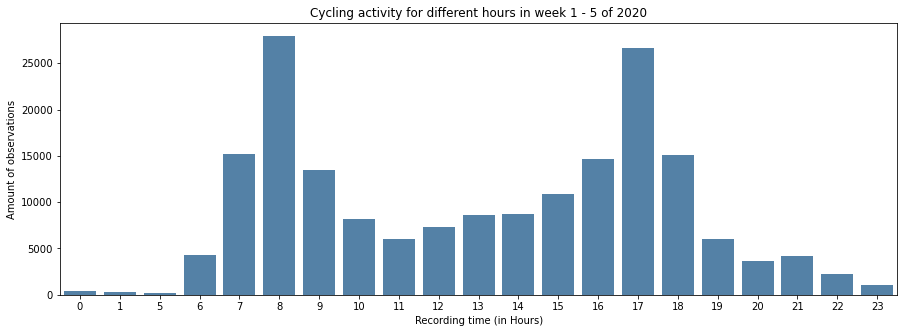

In [303]:
# Have a look at the distribution of time registrations
time_observations = snuffelfiets_df.groupby([snuffelfiets_df['recording_time'].dt.hour]).size()

# Convert series to a dataframe to use with Seaborn
time_observations = pd.DataFrame(time_observations).reset_index()

# Rename 0 column
time_observations = time_observations.rename(columns={0: "Count"})

# Create a distribution plot with Seaborn
fig, ax = plt.subplots(figsize=(15,5))

sns.barplot(data= time_observations,
            x='recording_time',
            y='Count',
            color='steelblue',
            ax=ax,
           );

ax.set_title('Cycling activity for different hours in week 1 - 5 of 2020');
plt.xlabel("Recording time (in Hours)");
plt.ylabel("Amount of observations");

### Trim dataset to observations between 06:00 and 20:00

In [99]:
# Trim dataset
geo_df[(geo_df['recording_time'].dt.month == 1)].sort_values('recording_time', ascending=True)

,Unnamed: 0,sensor,air_quality_observed_id,lon,lat,recording_time,trip_sequence,humidity,pm2_5,pressure,temperature,voltage,error_code,geometry,speed
89824,363517,80e32041372e5d360cbc5acefb6506fb,1598496,5.085445,52.097012,2020-01-06 12:00:50,0,61,9,975,7.8,3.98,0,POINT (5.08544 52.09701),22.1
179063,679842,f3220e4a25471ff971c8871a29e8a75c,1598510,5.101298,52.083504,2020-01-06 12:01:02,0,63,7,1032,8.4,4.01,0,POINT (5.10130 52.08350),16.7
179064,679843,f3220e4a25471ff971c8871a29e8a75c,1598532,5.100605,52.083866,2020-01-06 12:01:16,0,63,7,1032,8.5,4.00,0,POINT (5.10061 52.08387),16.0
179065,679844,f3220e4a25471ff971c8871a29e8a75c,1598548,5.099894,52.084213,2020-01-06 12:01:30,0,63,6,1032,8.5,4.01,0,POINT (5.09989 52.08421),16.0
179066,679845,f3220e4a25471ff971c8871a29e8a75c,1598562,5.099055,52.084553,2020-01-06 12:01:44,0,63,6,1032,8.5,4.00,0,POINT (5.09905 52.08455),17.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166209,622976,e1ff5e6bfd3be8138b1d6513d636f01e,24301273,5.143188,52.102833,2020-01-31 23:40:19,23,81,7,1006,13.7,3.88,0,POINT (5.14319 52.10283),16.1
166210,622977,e1ff5e6bfd3be8138b1d6513d636f01e,24301336,5.143570,52.103470,2020-01-31 23:40:33,23,81,8,1006,13.8,3.88,0,POINT (5.14357 52.10347),19.4
166211,622978,e1ff5e6bfd3be8138b1d6513d636f01e,24301337,5.143852,52.103977,2020-01-31 23:40:46,23,81,8,1007,13.8,3.88,0,POINT (5.14385 52.10398),16.5
166212,622979,e1ff5e6bfd3be8138b1d6513d636f01e,24301338,5.144623,52.104145,2020-01-31 23:40:59,23,81,8,1007,13.8,3.89,0,POINT (5.14462 52.10415),15.5


In [304]:
# Trim dataset
snuffelfiets_df = snuffelfiets_df[(snuffelfiets_df['recording_time'].dt.month == 1) 
                                  & (snuffelfiets_df['recording_time'].dt.hour >= 6) 
                                  & (snuffelfiets_df['recording_time'].dt.hour <= 20)]
snuffelfiets_df.describe()

,Unnamed: 0,air_quality_observed_id,lon,lat,trip_sequence,humidity,pm2_5,pressure,temperature,voltage,error_code,speed
count,168374.000000,1.683740e+05,168374.000000,168374.000000,168374.000000,168374.000000,168374.000000,1.683740e+05,168374.000000,168374.000000,168374.000000,168374.000000
mean,353786.301460,1.911660e+07,5.104301,52.088807,7.563721,69.043029,11.282223,5.610000e+04,11.482964,3.891017,229.680877,18.062722
std,200779.272129,6.984919e+06,0.037226,0.016860,6.695600,13.531268,10.673831,1.537304e+06,48.488560,0.135505,644.946972,5.414686
min,6.000000,1.598496e+06,4.974094,52.028873,0.000000,0.000000,1.000000,4.310000e+02,0.000000,3.210000,0.000000,5.100000
25%,175556.250000,1.111593e+07,5.084354,52.078117,2.000000,58.000000,4.000000,9.880000e+02,8.100000,3.760000,0.000000,14.600000
50%,368810.500000,2.306953e+07,5.109545,52.089405,6.000000,71.000000,7.000000,1.004000e+03,10.400000,3.870000,0.000000,18.200000
75%,519023.750000,2.364586e+07,5.129592,52.099190,11.000000,80.000000,15.000000,1.019000e+03,13.100000,4.010000,0.000000,22.000000
max,703237.000000,2.429548e+07,5.195016,52.137924,42.000000,100.000000,136.000000,4.294950e+07,6553.500000,4.220000,2592.000000,44.900000


### Have a look at humidity range of the sensors (Missing data)

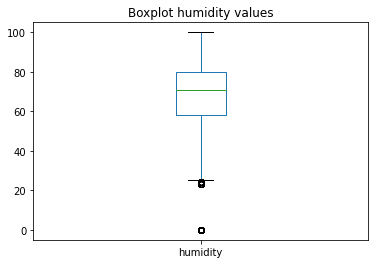

In [305]:
snuffelfiets_df.humidity.plot.box(title = 'Boxplot humidity values', showfliers=True);

In [306]:
snuffelfiets_df[snuffelfiets_df['humidity']<20]

,Unnamed: 0,sensor,air_quality_observed_id,lon,lat,recording_time,trip_sequence,humidity,pm2_5,pressure,temperature,voltage,error_code,geometry,speed
157835,593339,dc3540a81771f7f1ca5888dc97fc5cc7,23338701,5.036109,52.081165,2020-01-22 08:08:51,0,0,22,42949496,18.0,3.77,0,POINT (5.03611 52.08117),10.0
157836,593340,dc3540a81771f7f1ca5888dc97fc5cc7,23338702,5.035764,52.080429,2020-01-22 08:09:19,0,0,22,42949496,17.8,3.77,0,POINT (5.03576 52.08043),11.0
157837,593341,dc3540a81771f7f1ca5888dc97fc5cc7,23338703,5.035687,52.079842,2020-01-22 08:09:33,0,0,21,42949496,17.7,3.77,0,POINT (5.03569 52.07984),16.9
157838,593342,dc3540a81771f7f1ca5888dc97fc5cc7,23338704,5.035351,52.079235,2020-01-22 08:09:47,0,0,22,42949496,17.6,3.77,0,POINT (5.03535 52.07924),18.3
157839,593343,dc3540a81771f7f1ca5888dc97fc5cc7,23338705,5.035010,52.078640,2020-01-22 08:10:01,0,0,22,42949496,17.5,3.77,0,POINT (5.03501 52.07864),18.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158046,593670,dc3540a81771f7f1ca5888dc97fc5cc7,23521861,5.039431,52.082245,2020-01-23 18:38:57,3,0,50,42949498,6.7,3.74,0,POINT (5.03943 52.08224),17.0
158047,593671,dc3540a81771f7f1ca5888dc97fc5cc7,23521862,5.039065,52.081696,2020-01-23 18:39:10,3,0,51,42949498,6.7,3.74,0,POINT (5.03906 52.08170),18.3
158048,593672,dc3540a81771f7f1ca5888dc97fc5cc7,23521863,5.038427,52.081459,2020-01-23 18:39:24,3,0,51,42949498,6.7,3.73,0,POINT (5.03843 52.08146),13.1
158049,593673,dc3540a81771f7f1ca5888dc97fc5cc7,23521864,5.036940,52.081821,2020-01-23 18:39:52,3,0,46,42949498,6.7,3.74,0,POINT (5.03694 52.08182),14.1


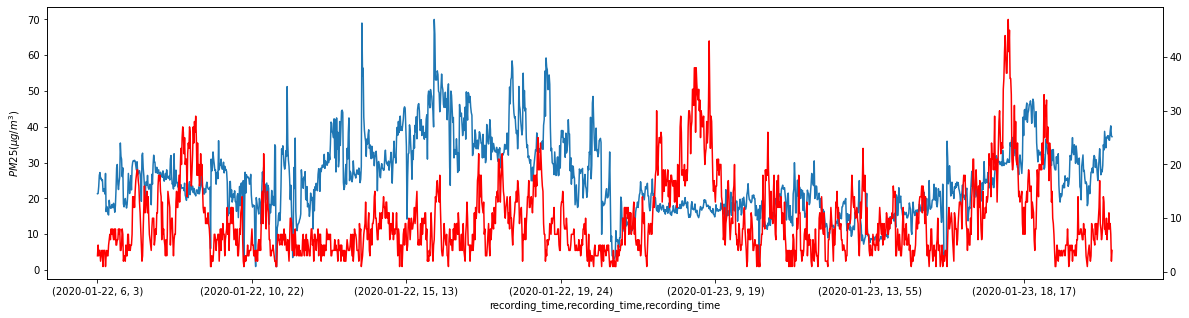

In [307]:
# Have a look at the pm2_5 values for this two days
missing_sensor = snuffelfiets_df[(snuffelfiets_df['recording_time'].dt.day == 22) | (snuffelfiets_df['recording_time'].dt.day == 23)]

# Plot the figure
fig, ax = plt.subplots(figsize=(20,5))

missing_sensor.groupby([missing_sensor['recording_time'].dt.date,
                        missing_sensor['recording_time'].dt.hour, 
                        missing_sensor['recording_time'].dt.minute])['pm2_5'].mean().plot(markersize=0.1, ax=ax);

plt.ylabel("$PM25 (µg/m^3)$");
ax2 = ax.twinx()

# Plot amount of observations
missing_sensor.groupby([missing_sensor['recording_time'].dt.date,
                        missing_sensor['recording_time'].dt.hour, 
                        missing_sensor['recording_time'].dt.minute])['pm2_5'].count().plot(markersize=0.1, ax=ax2, color='r');

plt.xlabel("Average PM2_5 values per minute");

In [308]:
missing_sensor.groupby([missing_sensor['recording_time'].dt.date,
                        missing_sensor['recording_time'].dt.hour, 
                        missing_sensor['recording_time'].dt.minute])['pm2_5'].mean().describe()

count    1643.000000
mean       25.380130
std        10.292986
min         1.000000
25%        17.750000
50%        23.750000
75%        31.645833
max        70.000000
Name: pm2_5, dtype: float64

### Have a look at temperature range of the sensors outliers

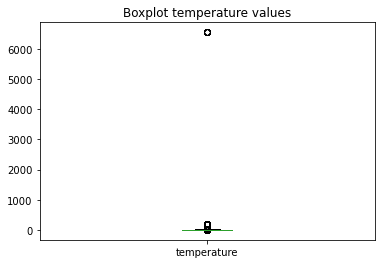

In [309]:
snuffelfiets_df.temperature.plot.box(title = 'Boxplot temperature values', showfliers=True);

In [310]:
snuffelfiets_df[snuffelfiets_df['temperature'] > 40]

,Unnamed: 0,sensor,air_quality_observed_id,lon,lat,recording_time,trip_sequence,humidity,pm2_5,pressure,temperature,voltage,error_code,geometry,speed
10896,43108,13a104c864267a1948cb8d219d3cc8fe,23211473,5.037265,52.110058,2020-01-21 08:01:31,5,98,35,1044,6553.3,3.79,0,POINT (5.03726 52.11006),9.5
10897,43109,13a104c864267a1948cb8d219d3cc8fe,23211474,5.037418,52.109039,2020-01-21 08:01:59,5,98,33,1044,6553.3,3.79,0,POINT (5.03742 52.10904),14.6
10898,43110,13a104c864267a1948cb8d219d3cc8fe,23211476,5.037452,52.108463,2020-01-21 08:02:13,5,98,32,1044,6553.3,3.76,0,POINT (5.03745 52.10846),17.3
10899,43111,13a104c864267a1948cb8d219d3cc8fe,23211985,5.037578,52.106396,2020-01-21 08:03:06,5,98,26,1044,6553.3,3.78,0,POINT (5.03758 52.10640),15.6
10900,43112,13a104c864267a1948cb8d219d3cc8fe,23211986,5.037616,52.105873,2020-01-21 08:03:19,5,98,25,1044,6553.3,3.77,0,POINT (5.03762 52.10587),16.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157801,590269,dabc5afb8e3e7b10ac0d90e9f38d24bb,22841128,5.107946,52.055145,2020-01-16 17:36:11,6,90,5,1046,197.8,3.76,0,POINT (5.10795 52.05515),16.0
157802,590270,dabc5afb8e3e7b10ac0d90e9f38d24bb,22841129,5.107139,52.054008,2020-01-16 17:36:37,6,90,5,1046,197.8,3.77,0,POINT (5.10714 52.05401),19.1
157803,590271,dabc5afb8e3e7b10ac0d90e9f38d24bb,22841601,5.106357,52.053520,2020-01-16 17:36:51,6,90,5,1046,197.8,3.78,0,POINT (5.10636 52.05352),19.7
157804,590272,dabc5afb8e3e7b10ac0d90e9f38d24bb,22841602,5.105587,52.053127,2020-01-16 17:37:04,6,90,4,1045,197.8,3.77,0,POINT (5.10559 52.05313),19.0


##  B) Have a look at the mean PM2_5 values registered by each sensor for this time period

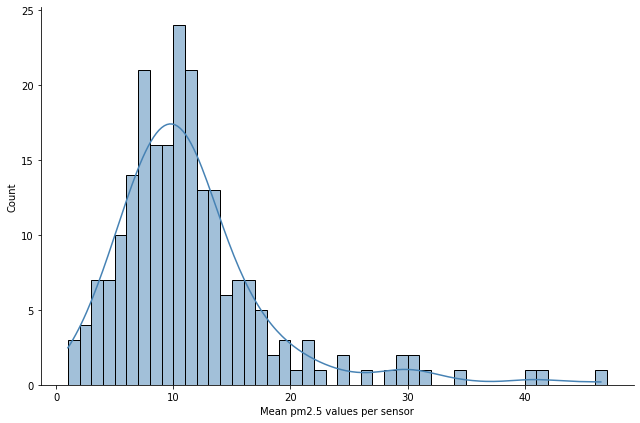

In [312]:
# Have a look at the counts for mean pm2_5 values registered per sensor in this time window
pmcounts = snuffelfiets_df.groupby('sensor')['pm2_5'].mean()

# Convert series to a dataframe to use with Seaborn
pmcounts = pd.DataFrame(pmcounts).reset_index()

# Create a distribution plot with Seaborn
fig = sns.displot(pmcounts,
                  x='pm2_5',
                  binwidth=1,
                  kde=True,
                  height=6, aspect=3/2, color='steelblue'
                 );

fig.set_axis_labels('Mean pm2.5 values per sensor', 'Count');

From this histogram it can be seen that the most sensors register a mean value between 1 and 20. Higher registrations are rare and could give a sign of defect sensors. Let's have a look at the boxplot for this distribution. Especially the values > 40 are weird

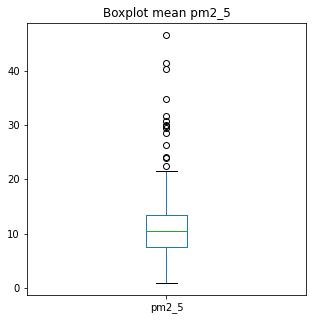

In [313]:
# plot a boxplot of the mean registrations for the sensors to find out what is seen as outliers
fig1, ax = plt.subplots(figsize=(5,5))
pmcounts.pm2_5.plot.box(title = 'Boxplot mean pm2_5', showfliers=True, ax=ax);

From the boxplot outliers are shown above the Q3 + 1,5 IQR (which corresponds to approx. 22 ug/m³). Let's get these sensor names and look at the observations in the original dataframe for these sensors

In [314]:
# Create a dataframe with the outlier sensors
Outliers = pmcounts[pmcounts['pm2_5'] > 22].reset_index(drop=True)
Outliers

,sensor,pm2_5
0,04cc737d21f1c30fe4620dc32fa7aa67,22.550725
1,122d4a8ce2e29b2cff0ba26ca8c177a5,40.271739
2,1235da6aac12af0ec2a7f1b5cea6e535,28.472973
3,1fafde79a2000ecd986c8b88b4ad0647,24.087805
4,28b921dee1d8ff1c6e6340eff3ddec00,29.545455
5,3942d2dcd2b5b8e0700a6d350b6aad7b,34.752577
6,4344bbdbd9256b5ee6e539da55d0d5b5,41.341463
7,51b81abb113ca83d55451bf0f486b1a3,31.686047
8,aa4c1a2bc3f5d18c64b99546f7b4793d,30.008403
9,ca9c50a5009f138b5485f4d8f7490476,24.000000


In [315]:
# Have a look at the full data and obervations of these sensors by merging the outlier sensors with the original dataset
Outliers = pd.merge(snuffelfiets_df, Outliers, on='sensor').reset_index(drop=True)

Maybe the amount of observations tell us something about the reason for the sensors being outlier. Let's have a look!

In [316]:
# Have a look at the amount of observations done by each sensor
Outliers.groupby('sensor').size().sort_values(ascending=False)

sensor
1fafde79a2000ecd986c8b88b4ad0647    615
dc3540a81771f7f1ca5888dc97fc5cc7    216
122d4a8ce2e29b2cff0ba26ca8c177a5    184
51b81abb113ca83d55451bf0f486b1a3    172
04cc737d21f1c30fe4620dc32fa7aa67    138
ca9c50a5009f138b5485f4d8f7490476    138
aa4c1a2bc3f5d18c64b99546f7b4793d    119
e71f814cef9e85fcd62e66d09bb94edf    118
3942d2dcd2b5b8e0700a6d350b6aad7b     97
d4c2e80f145c41970e069f53faca3150     92
4344bbdbd9256b5ee6e539da55d0d5b5     82
1235da6aac12af0ec2a7f1b5cea6e535     74
28b921dee1d8ff1c6e6340eff3ddec00     11
ded993bb83bc5611c5950de522ce367c     11
dtype: int64

From this we can see that there are a couple of sensor with a low number of observations. This is interesting as most of the sensors seem to have a higher amount of observations, but still give us a higher mean pm2_5 value for this period.

## C) Have a look at the distribution of observations counts

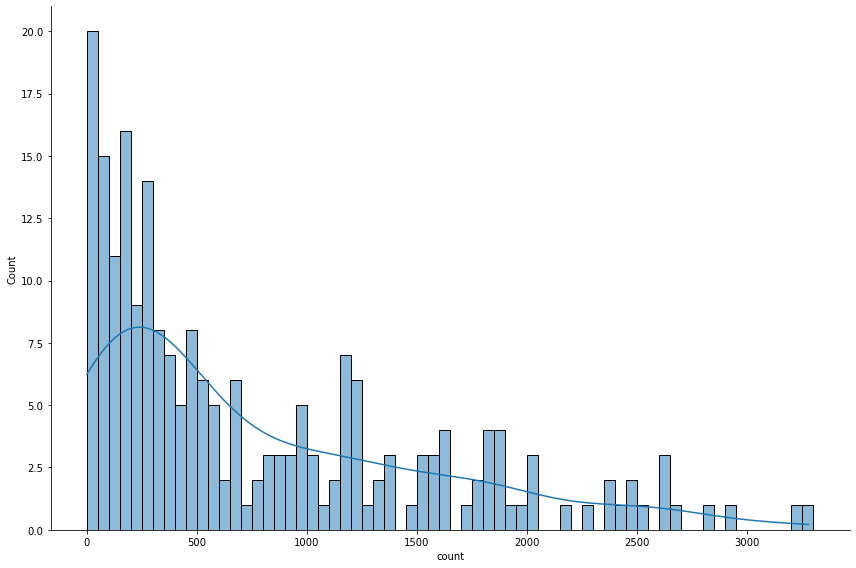

In [317]:
# Have a look at the counts for mean pm2_5 values registered per sensor in this time window
observations = snuffelfiets_df.groupby('sensor').size().sort_values(ascending=False)

# Convert series to a dataframe to use with Seaborn
observations = pd.DataFrame(observations).reset_index()
observations.columns = ['sensor', 'count']

# Create a distribution plot with Seaborn
sns.displot(observations,
            x='count',
            binwidth=50,
            kde=True,
            height=8, aspect=3/2);

The distribution plot shows a peak for observations count from 0-50 and then slowly decreasing for the number of low observations. The sensor counts up untill 50 however are of interest, because this could suggest a very low use (measurements are done once every 10 seconds!) This needs some further investigation

In [318]:
# Get a dataframe with the sensors that have < 50 observations
Low_observations = observations[observations['count'] <= 50]

# Get the original data for these sensors with low observations
Low_observations = pd.merge(snuffelfiets_df, Low_observations, on='sensor').reset_index(drop=True)
Low_observations[1:15].drop(columns=['Unnamed: 0', 'error_code', 'geometry', 'voltage'])

,sensor,air_quality_observed_id,lon,lat,recording_time,trip_sequence,humidity,pm2_5,pressure,temperature,speed,count
1,0538c2375339eca850d69c6b56912b65,10732291,5.192655,52.077858,2020-01-09 18:56:38,12,77,6,1008,14.5,38.6,8
2,0538c2375339eca850d69c6b56912b65,11011718,5.193349,52.077789,2020-01-13 06:54:38,14,51,5,1019,15.2,33.9,8
3,0538c2375339eca850d69c6b56912b65,11167338,5.193408,52.077751,2020-01-14 07:31:19,1,71,2,1002,12.6,31.2,8
4,0538c2375339eca850d69c6b56912b65,22781870,5.185457,52.076870,2020-01-16 14:39:11,5,69,8,1022,12.1,20.7,8
5,0538c2375339eca850d69c6b56912b65,23096927,5.193204,52.077824,2020-01-20 07:06:02,25,60,4,1048,8.1,15.2,8
6,0538c2375339eca850d69c6b56912b65,23199501,5.192857,52.077892,2020-01-21 06:48:02,2,58,9,1043,7.0,27.7,8
7,0538c2375339eca850d69c6b56912b65,23876470,5.193204,52.077843,2020-01-28 06:38:42,1,66,5,989,10.6,31.9,8
8,28b921dee1d8ff1c6e6340eff3ddec00,23343619,5.156180,52.098255,2020-01-22 08:36:10,2,91,31,1037,5.4,16.0,11
9,28b921dee1d8ff1c6e6340eff3ddec00,23343620,5.155112,52.098034,2020-01-22 08:36:24,2,91,32,1037,5.4,19.9,11
10,28b921dee1d8ff1c6e6340eff3ddec00,23343622,5.154345,52.097797,2020-01-22 08:36:37,2,91,31,1037,5.4,16.9,11


From the table it can be observed that the first sensors consists of observations with very different time stamps and trip_sequence. This could be explained due to the cleaning steps done till this point (the observations show a wide range of speeds between 15 and 38 km/h). The seconds sensor shows a valid measurement as this looks like a good bike trip with observations every 10 seconds with a speeds of around 12km/h. This means that it's not the amount of observations that are important for a valid measurement, but rather the amount of valid observations within a single trip (trip sequence). As the sensor registers every 10s, the lower boundary could be set to > 20 observations (bike trip of ~3 min) for a trip. If a sensor registers < 20 observations within a single trip to filter out noise, with observations < 20 the trip is not valid and seen as noise and thus will be discarded from the dataset. 

## C) Have a look at the amount of observations within a trip sequence

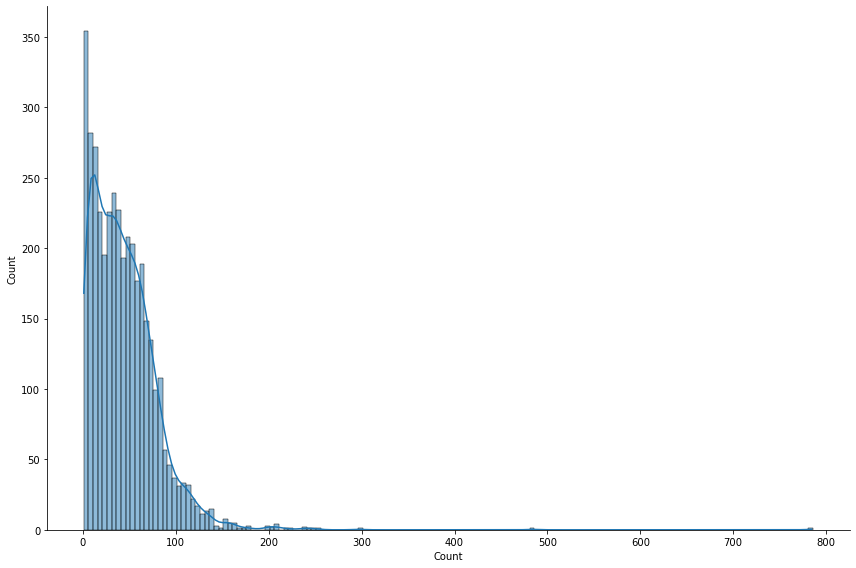

In [319]:
# Create a copy and convert the recording time column to a datetime format
copy_snuffelfiets_df = snuffelfiets_df.copy()

# Convert the datetime object to datetime format for analysis
copy_snuffelfiets_df['recording_time'] = pd.to_datetime(copy_snuffelfiets_df['recording_time'])

# Sort the observations by sensor, date and trip sequence
tripminimum = copy_snuffelfiets_df.groupby(['sensor',  copy_snuffelfiets_df['recording_time'].dt.date, 'trip_sequence']).size()

# Convert series to a dataframe to use with Seaborn
tripminimum = pd.DataFrame(tripminimum).reset_index()

# Rename count column to Count
tripminimum = tripminimum.rename(columns={0: "Count"})

# Get a distribution plot from the values
sns.displot(tripminimum, x='Count', binwidth=5, kde=True, height=8, aspect=12/8)

From this distribution plot can be seen that a there are quite some trip sequences within the dataset where < 20 observations are made in this time period

## D) Delete observations with <= 20 observations within a single trip

In [320]:
# Create a dataframe of the sensors and trip sequences for the invalid trips (< 20 observations)
invalid = tripminimum[tripminimum['Count'] <= 20]
invalid = invalid.sort_values(by=['sensor', 'Count'], ascending=False)
invalid

,sensor,recording_time,trip_sequence,Count
3839,fe8fdeaee329155d900813c2dbf4471e,2020-01-28,1,19
3835,fe8fdeaee329155d900813c2dbf4471e,2020-01-25,9,7
3836,fe8fdeaee329155d900813c2dbf4471e,2020-01-25,10,2
3815,fc3390e472769204c31cc9e0d83bf2bd,2020-01-13,15,14
3814,fc3390e472769204c31cc9e0d83bf2bd,2020-01-13,14,12
...,...,...,...,...
6,00da8ce393d693c511be23980a82574e,2020-01-21,1,18
7,00da8ce393d693c511be23980a82574e,2020-01-21,2,15
2,00da8ce393d693c511be23980a82574e,2020-01-07,4,13
1,00da8ce393d693c511be23980a82574e,2020-01-07,3,9


In [321]:
# Have a look at the amount of invalid observations
invalid['Count'].sum()

10790

In [322]:
# Convert the recording time column to a datetime format
invalid['recording_time'] = pd.to_datetime(invalid['recording_time'])

# Drop unneccesary column
invalid = invalid.drop(columns=['Count'])
invalid

,sensor,recording_time,trip_sequence
3839,fe8fdeaee329155d900813c2dbf4471e,2020-01-28,1
3835,fe8fdeaee329155d900813c2dbf4471e,2020-01-25,9
3836,fe8fdeaee329155d900813c2dbf4471e,2020-01-25,10
3815,fc3390e472769204c31cc9e0d83bf2bd,2020-01-13,15
3814,fc3390e472769204c31cc9e0d83bf2bd,2020-01-13,14
...,...,...,...
6,00da8ce393d693c511be23980a82574e,2020-01-21,1
7,00da8ce393d693c511be23980a82574e,2020-01-21,2
2,00da8ce393d693c511be23980a82574e,2020-01-07,4
1,00da8ce393d693c511be23980a82574e,2020-01-07,3


In [323]:
# Create a copy of the original dataframe
copy = snuffelfiets_df.copy()

# Transform string into datetime format and save the date only
copy['recording_time'] = pd.to_datetime(copy['recording_time'])
copy['recording_time'] = copy['recording_time'].dt.date
copy['recording_time'] = pd.to_datetime(copy['recording_time'])

# Create a dataframe that contains the observations of the invalid sensors and trip sequences
copy = pd.merge(copy, invalid, how ='inner', on = ['sensor', 'recording_time', 'trip_sequence']).sort_values(by=['sensor', 'trip_sequence'], ascending=False)

# Rename Unnamed column to original index
copy = copy.rename(columns={'Unnamed: 0': "original_index"})
copy['original_index'].nunique()

10790

In [324]:
# Create a dataframe without the unrealistic observations
mask = snuffelfiets_df['Unnamed: 0'].isin(copy['original_index'])
clean_df = snuffelfiets_df[~mask]
clean_df

,Unnamed: 0,sensor,air_quality_observed_id,lon,lat,recording_time,trip_sequence,humidity,pm2_5,pressure,temperature,voltage,error_code,geometry,speed
0,6,0007645008afc8b5ad9e9d0acd907681,24115297,5.151163,52.058880,2020-01-30 08:41:37,0,41,2,1015,18.4,4.17,0,POINT (5.15116 52.05888),24.5
1,7,0007645008afc8b5ad9e9d0acd907681,24115298,5.151027,52.059643,2020-01-30 08:41:50,0,41,3,1014,18.2,4.17,0,POINT (5.15103 52.05964),23.6
2,8,0007645008afc8b5ad9e9d0acd907681,24115299,5.150907,52.060444,2020-01-30 08:42:03,0,41,2,1013,18.0,4.17,0,POINT (5.15091 52.06044),24.8
3,9,0007645008afc8b5ad9e9d0acd907681,24115300,5.150247,52.061207,2020-01-30 08:42:16,0,41,3,1013,17.8,4.17,0,POINT (5.15025 52.06121),26.6
4,10,0007645008afc8b5ad9e9d0acd907681,24115301,5.149693,52.061855,2020-01-30 08:42:30,0,41,3,1012,17.6,4.17,0,POINT (5.14969 52.06186),21.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184912,703233,fe8fdeaee329155d900813c2dbf4471e,23955866,5.088865,52.118740,2020-01-28 18:02:35,2,64,3,1005,8.1,3.72,0,POINT (5.08886 52.11874),23.2
184913,703234,fe8fdeaee329155d900813c2dbf4471e,23955867,5.087642,52.118855,2020-01-28 18:02:48,2,64,2,1005,8.1,3.69,0,POINT (5.08764 52.11885),23.5
184914,703235,fe8fdeaee329155d900813c2dbf4471e,23955868,5.086446,52.118965,2020-01-28 18:03:01,2,64,2,1005,8.1,3.71,0,POINT (5.08645 52.11897),22.9
184915,703236,fe8fdeaee329155d900813c2dbf4471e,23955869,5.085496,52.119152,2020-01-28 18:03:14,2,64,2,1005,8.1,3.72,0,POINT (5.08550 52.11915),18.9


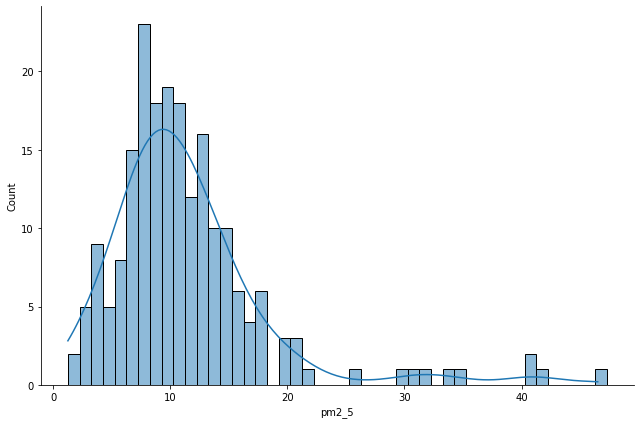

In [325]:
# Have a look at the counts for mean pm2_5 values registered per sensor in this time window
clean_df_pm25 = clean_df.groupby(['sensor'])['pm2_5'].mean()

# Convert series to a dataframe to use with Seaborn
clean_df_pm25 = pd.DataFrame(clean_df_pm25).reset_index()

# Have a new look at the pm25 distribution plot
sns.displot(clean_df_pm25, x='pm2_5', binwidth = 1, kde=True, height=6, aspect=3/2)

The new distribution plot still shows outliers. This should be investigated further

In [326]:
# Export the GeoDataframe to csv file to save time on calculation
clean_df.to_csv("clean_df.csv", index=False)

### Read the cleaned df for time saving purposes in coding

In [106]:
# Read the cleaned df file for further investigations
snuffelfiets_df_clean = pd.read_csv("clean_df.csv", low_memory=False, index_col=0).reset_index(drop=True)

# Create GeoDataFrame from csv
geo_df = gpd.GeoDataFrame(snuffelfiets_df_clean, geometry = gpd.points_from_xy(snuffelfiets_df_clean['lon'], snuffelfiets_df_clean['lat'], crs="EPSG:4326"))

# Convert GeoDataFrame to right CRS
geo_df = geo_df.to_crs("EPSG:28992")

# Export the geodataframe to a shapefile
geo_df.to_file('PM_observations.shp', driver='ESRI Shapefile')

# Convert the datetime object to a datetime format
geo_df['recording_time'] = pd.to_datetime(geo_df['recording_time'])

# Retrieve data with municipal boundaries from PDOK
geodata_url = 'https://geodata.nationaalgeoregister.nl/cbsgebiedsindelingen/wfs?request=GetFeature&service=WFS&version=2.0.0&typeName=cbs_gemeente_2017_gegeneraliseerd&outputFormat=json'
municipal_boundaries = gpd.read_file(geodata_url)

# Get the geometry of Utrecht
Utrechtgeo = municipal_boundaries[municipal_boundaries['statnaam'] == 'Utrecht']

# Transform to right CRS
Utrechtgeo = Utrechtgeo.to_crs("EPSG:28992").reset_index(drop=True)

## E) Investigate the outliers.

In [7]:
outliers = geo_df.groupby(['sensor'])['pm2_5'].mean()

# Convert series to a dataframe to use with Seaborn
outliers = pd.DataFrame(outliers).reset_index()

# Get the outlier sensors
outliers = outliers[outliers['pm2_5'] > 22].reset_index(drop=True)

# Merge with original df for full data
outliers = pd.merge(geo_df, outliers, on='sensor').reset_index(drop=True)

In [9]:
outliers.groupby(['sensor', outliers['recording_time'].dt.date]).agg(
    PM25_mean = ('pm2_5_x','mean'),
    PM25_std  = ('pm2_5_x','std'),
    PM25_max  = ('pm2_5_x','max'),
    PM25_min  = ('pm2_5_x','min'),
    PM25_count =('pm2_5_x', 'count')
)

PM25_mean   PM25_std  \
sensor                           recording_time                         
122d4a8ce2e29b2cff0ba26ca8c177a5 2020-01-21      40.786164   9.807234   
1235da6aac12af0ec2a7f1b5cea6e535 2020-01-22      54.351351   9.196063   
                                 2020-01-29       2.360000   0.489898   
1fafde79a2000ecd986c8b88b4ad0647 2020-01-23      23.922330   1.913263   
                                 2020-01-24      43.374468  13.448707   
                                 2020-01-27      14.102273   1.553933   
                                 2020-01-28       1.803030   0.706447   
                                 2020-01-31       6.988235   1.636591   
3942d2dcd2b5b8e0700a6d350b6aad7b 2020-01-25      34.752577   3.775003   
4344bbdbd9256b5ee6e539da55d0d5b5 2020-01-21      41.341463   8.805469   
51b81abb113ca83d55451bf0f486b1a3 2020-01-24      31.686047   3.248973   
aa4c1a2bc3f5d18c64b99546f7b4793d 2020-01-10       2.702703   4.033642   
                                 2020-01-22      42.329268   5.459288   
d4c2e80f145c41970e069f53faca3150 2020-01-21      30.826087   6.700186   
dc3540a81771f7f1ca5888dc97fc5cc7 2020-01-22      43.000000  19.066599   
                                 2020-01-23      53.356164   4.220880   
e71f814cef9e85fcd62e66d09bb94edf 2020-01-24      40.534884   4.767693   

                                                 PM25_max  PM25_min  \
sensor                           recording_time                       
122d4a8ce2e29b2cff0ba26ca8c177a5 2020-01-21            61        24   
1235da6aac12af0ec2a7f1b5cea6e535 2020-01-22            77        42   
                                 2020-01-29             3         2   
1fafde79a2000ecd986c8b88b4ad0647 2020-01-23            28        19   
                                 2020-01-24            74        27   
                                 2020-01-27            17        11   
                                 2020-01-28             4         1   
                                 2020-01-31            10         4   
3942d2dcd2b5b8e0700a6d350b6aad7b 2020-01-25            41        23   
4344bbdbd9256b5ee6e539da55d0d5b5 2020-01-21            61        26   
51b81abb113ca83d55451bf0f486b1a3 2020-01-24            39        26   
aa4c1a2bc3f5d18c64b99546f7b4793d 2020-01-10            23         1   
                                 2020-01-22            55        30   
d4c2e80f145c41970e069f53faca3150 2020-01-21            45        14   
dc3540a81771f7f1ca5888dc97fc5cc7 2020-01-22            80        20   
                                 2020-01-23            68        45   
e71f814cef9e85fcd62e66d09bb94edf 2020-01-24            48        30   

                                                 PM25_count  
sensor                           recording_time              
122d4a8ce2e29b2cff0ba26ca8c177a5 2020-01-21             159  
1235da6aac12af0ec2a7f1b5cea6e535 2020-01-22              37  
                                 2020-01-29              25  
1fafde79a2000ecd986c8b88b4ad0647 2020-01-23             103  
                                 2020-01-24             235  
                                 2020-01-27              88  
                                 2020-01-28              66  
                                 2020-01-31              85  
3942d2dcd2b5b8e0700a6d350b6aad7b 2020-01-25              97  
4344bbdbd9256b5ee6e539da55d0d5b5 2020-01-21              82  
51b81abb113ca83d55451bf0f486b1a3 2020-01-24             172  
aa4c1a2bc3f5d18c64b99546f7b4793d 2020-01-10              37  
                                 2020-01-22              82  
d4c2e80f145c41970e069f53faca3150 2020-01-21              92  
dc3540a81771f7f1ca5888dc97fc5cc7 2020-01-22             143  
                                 2020-01-23              73  
e71f814cef9e85fcd62e66d09bb94edf 2020-01-24              43

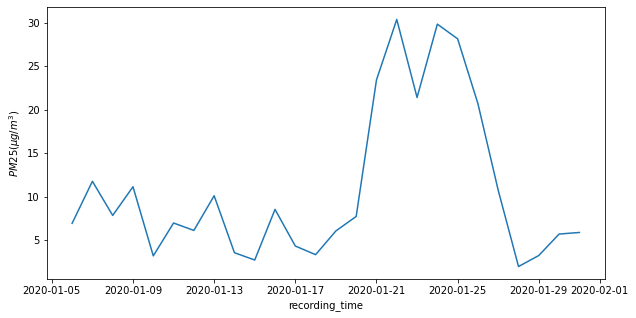

In [14]:
# Plot the figure
fig, ax = plt.subplots(figsize=(10,5))

geo_df.groupby([geo_df['recording_time'].dt.date])['pm2_5'].mean().plot(markersize=0.1, ax=ax);

plt.ylabel("$PM25 (µg/m^3)$");

Analyzing the above data, the sensors were mostly active between 22 and 28 january where PM2_5 values are overall higher, therefore these sensors are not removed from the dataset

# AGGREGATE VALUES INTO A 1 km² GRID  

a) Analyze daily data    
b) Plot cycling activity for a week  
c) Analyze hourly data  
d) Retrieve statistics for the 1 x 1 km² grid on daily basis

## A) Analyze daily mean values and observations

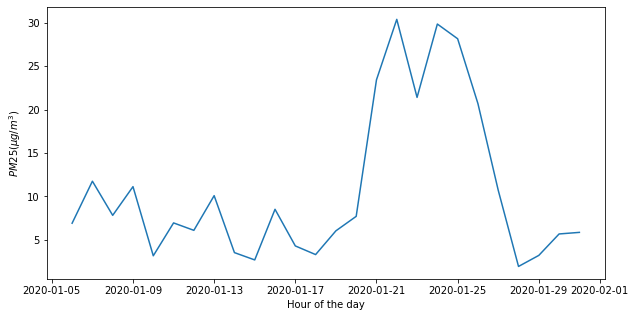

In [15]:
# Have a look at the different days and hours and the mean pm2_5 values for Utrecht of all sensors combined on daily basis
dates = geo_df.groupby([geo_df['recording_time'].dt.date])['pm2_5'].mean()

# Plot the figure
fig, ax = plt.subplots(figsize=(10,5))

dates.plot(markersize=0.1, ax=ax)
plt.xlabel("Hour of the day");
plt.ylabel("$PM25 (µg/m^3)$");

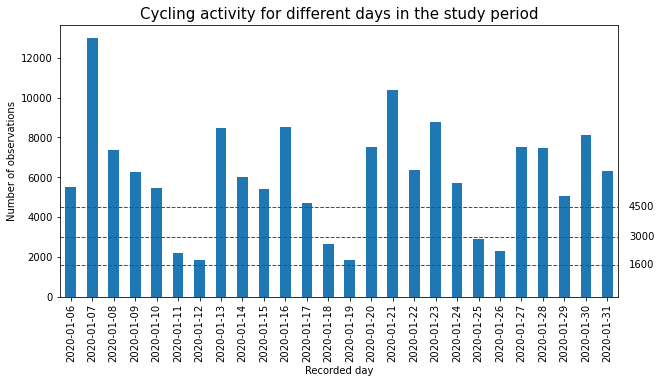

In [119]:
# Have a look at the distribution of registered observations per day
Counts = geo_df.groupby([geo_df['recording_time'].dt.date]).size()

# plot the bar figure for each day
fig, ax = plt.subplots(figsize=(10,5))

Counts.plot.bar(ax=ax)
plt.xlabel("Recorded day")
plt.ylabel("Number of observations")
plt.axhline(y=1600, linewidth=1, color='r', ls = '--')
plt.axhline(y=3000, linewidth=1, color='r', ls = '--')
plt.axhline(y=4500, linewidth=1, color='r', ls = '--')
ax.text(26, 1450, 1600)
ax.text(26, 2850, 3000)
ax.text(26, 4350, 4500)
ax.set_title('Cycling activity for different days in the study period', fontsize = 15);

From the observation count a pattern could be detected where the most cycling activity is on monday and this decreases throughout the week. Where the weekend has the lowest cycling activity. It could be of interest to see how the activity is distributed throughout the city between weekdays and weekend days

  ## B) Have a look at the cycling activity for the week of the 6th of January

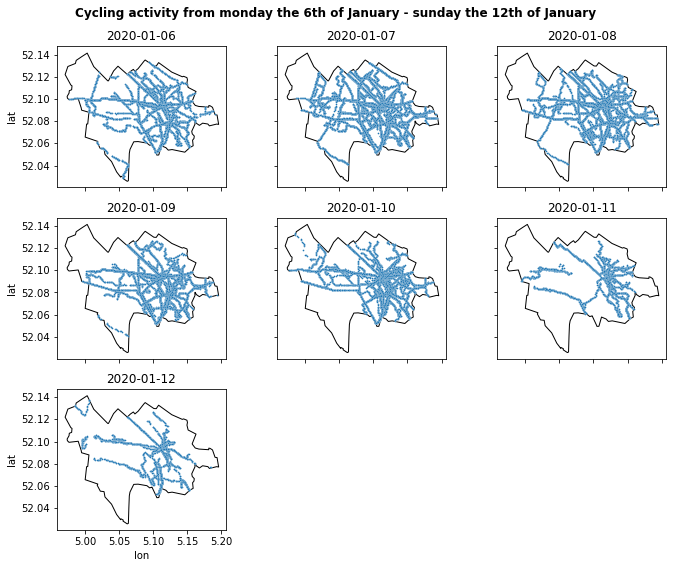

In [86]:
# Analyze subplots the entire week
nrow = 3
ncol = 3

# Convert Utrechtgeo to EPSG:4326 for use in lon lat
Utrechtbound = Utrechtgeo.to_crs("EPSG:4326")

fig, ax = plt.subplots(nrow, ncol, sharex='col', sharey='row', figsize=(10, 8))

# axes are in a two-dimensional array, indexed by [row, col]
for i in range(nrow):
    for j in range (ncol):
        Smallcount = geo_df.loc[(geo_df['recording_time'].dt.month) == 1]
        if i == 0:
            Smallcount = Smallcount.loc[(geo_df['recording_time'].dt.day) == i+j+6].reset_index()
        elif i == 1:
            Smallcount = Smallcount.loc[(geo_df['recording_time'].dt.day) == i+j+8].reset_index()
        else:
            Smallcount = Smallcount.loc[(geo_df['recording_time'].dt.day) == i+j+10].reset_index()
        
        # Plot the municipality of Utrecht
        Utrechtbound.plot(color='white', edgecolor='black', ax = ax[i, j])
        
        # Plot the cycling activity for the 7th of January
        sns.scatterplot(data=Smallcount,
                        x="lon", y="lat",
                        ax = ax[i, j],
                        s = 3
                       )
        
        # Get the date from the filtered dataframe to use in the subplot title
        Date = Smallcount.loc[0, 'recording_time'].date()
        ax[i, j].set_title(Date)

# Remove the plot figure for the monday of the next week
fig.delaxes(ax[2,1])
fig.delaxes(ax[2,2])

# Set general title for the subplots
fig.suptitle('Cycling activity from monday the 6th of January - sunday the 12th of January', fontweight = "heavy", fontsize = 12)
fig.subplots_adjust(top=0.9)
fig.tight_layout()

## C) Analyze daily mean values and observations

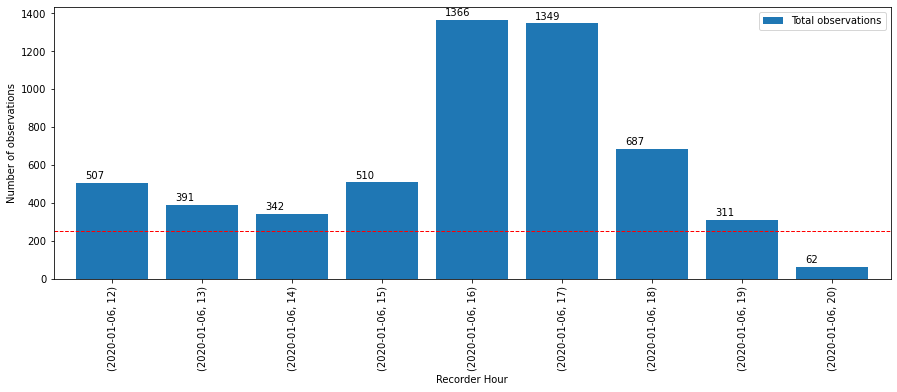

In [107]:
# Have a look at observation distribution for a single day (6th of january) for every hour
new_df = geo_df[(geo_df['recording_time'].dt.month == 1) & (geo_df['recording_time'].dt.day == 6)].reset_index()

hour_observations = new_df.groupby([new_df['recording_time'].dt.date, new_df['recording_time'].dt.hour]).size()

fig, ax = plt.subplots(figsize=(15,5))

# plot the bar figure for each day
hour_observations.plot.bar(width= 0.8, ax=ax)

# location for the annotated text
j = 20

# Annotating the bar plot with the values (total death count)
for i in range(len(hour_observations)):
    ax.annotate(hour_observations[i], (-0.3 + i, hour_observations[i] + j))

# Creating the legend of the bars in the plot
plt.legend(labels = ['Total observations'])

plt.xlabel("Recorder Hour");
plt.ylabel("Number of observations");
plt.axhline(y=250, linewidth=1, color='r', ls = '--');

### Categorical plot with Seaborn to plot different days in a single plot

In [108]:
# Copy df
day_df = geo_df.copy()

# Create column in dataframe which contains the day value
day_df['day'] = geo_df['recording_time'].dt.date
day_df

,sensor,air_quality_observed_id,lon,lat,recording_time,trip_sequence,humidity,pm2_5,pressure,temperature,voltage,error_code,geometry,speed,day
0,0007645008afc8b5ad9e9d0acd907681,24115297,5.151163,52.058880,2020-01-30 08:41:37,0,41,2,1015,18.4,4.17,0,POINT (138811.970 452312.832),24.5,2020-01-30
1,0007645008afc8b5ad9e9d0acd907681,24115298,5.151027,52.059643,2020-01-30 08:41:50,0,41,3,1014,18.2,4.17,0,POINT (138802.893 452397.745),23.6,2020-01-30
2,0007645008afc8b5ad9e9d0acd907681,24115299,5.150907,52.060444,2020-01-30 08:42:03,0,41,2,1013,18.0,4.17,0,POINT (138794.974 452486.899),24.8,2020-01-30
3,0007645008afc8b5ad9e9d0acd907681,24115300,5.150247,52.061207,2020-01-30 08:42:16,0,41,3,1013,17.8,4.17,0,POINT (138749.960 452571.930),26.6,2020-01-30
4,0007645008afc8b5ad9e9d0acd907681,24115301,5.149693,52.061855,2020-01-30 08:42:30,0,41,3,1012,17.6,4.17,0,POINT (138712.198 452644.205),21.0,2020-01-30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157579,fe8fdeaee329155d900813c2dbf4471e,23955866,5.088865,52.118740,2020-01-28 18:02:35,2,64,3,1005,8.1,3.72,0,POINT (134566.818 458988.504),23.2,2020-01-28
157580,fe8fdeaee329155d900813c2dbf4471e,23955867,5.087642,52.118855,2020-01-28 18:02:48,2,64,2,1005,8.1,3.69,0,POINT (134483.135 459001.581),23.5,2020-01-28
157581,fe8fdeaee329155d900813c2dbf4471e,23955868,5.086446,52.118965,2020-01-28 18:03:01,2,64,2,1005,8.1,3.71,0,POINT (134401.246 459014.228),22.9,2020-01-28
157582,fe8fdeaee329155d900813c2dbf4471e,23955869,5.085496,52.119152,2020-01-28 18:03:14,2,64,2,1005,8.1,3.72,0,POINT (134336.277 459035.295),18.9,2020-01-28


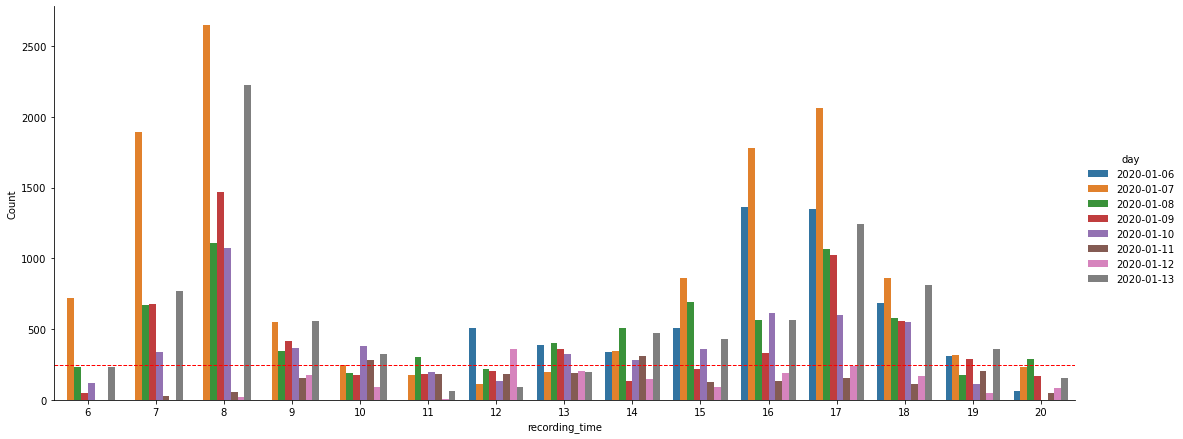

In [109]:
# Have a look at observation distribution for a single day (6th of january) for every hour
new_df = day_df[(geo_df['recording_time'].dt.month == 1) & (geo_df['recording_time'].dt.day >= 6) & (geo_df['recording_time'].dt.day <= 13)].reset_index()

hour_observations = new_df.groupby(['day', new_df['recording_time'].dt.hour]).size().reset_index()

# Convert series to a dataframe to use with Seaborn
hour_observations = pd.DataFrame(hour_observations)

# Rename count column to Count
hour_observations = hour_observations.rename(columns={0: "Count"})

sns.catplot(x = 'recording_time',       # x variable name
            y = 'Count',       # y variable name
            hue = 'day',  # group variable name
            data = hour_observations,     # dataframe to plot
            kind = 'bar',
            height=6, aspect=5/2
           )

plt.axhline(y=250, linewidth=1, color='r', ls = '--');

## D) Retrieve statistics for 1 x 1 km² grid

In [111]:
# Load the gridded raster file
grid = gpd.read_file('GridPoly.shp')

### Have a look at the cycling activity within the 1 x 1 km² grid

<AxesSubplot:>

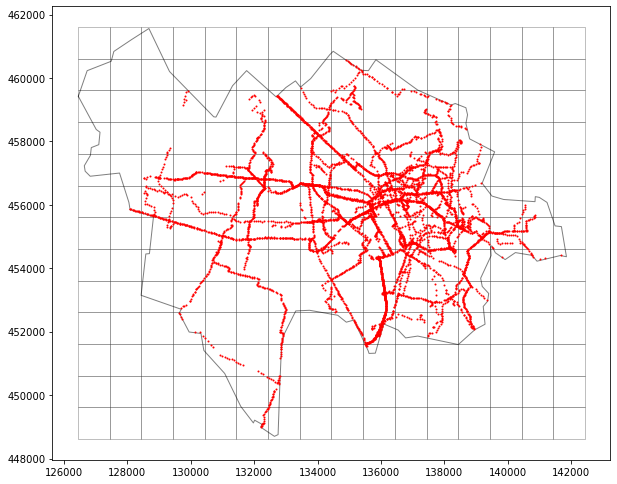

In [182]:
# Plot Utrecht
ax = Utrechtgeo.plot(figsize=(10, 10), color='white', edgecolor='black')

# Plot the new grid for Utrecht
grid.plot(ax=ax, markersize = 1, edgecolor='black', linewidth = 0.5, alpha = 0.5, facecolor = 'white')

# Create a dataframe with observations for the 6th of January
firstjanuary = geo_df[(geo_df['recording_time'].dt.month == 1) & (geo_df['recording_time'].dt.day == 22)]

# plot observations for the first of january
firstjanuary.plot(ax=ax, markersize = 1, c = 'r')

### Spatially join the observations with the polygon in which they are registered (points in polygon)

In [183]:
# Merge the observations for the first of january with the grid polygons
mergedjanuary = gpd.sjoin(firstjanuary, grid, how="left")

# Drop columns that are not of interest
mergedjanuary = mergedjanuary.drop(columns=['lon', 'lat', 'left', 'top', 'right', 'bottom'])

stats_pt  = mergedjanuary.groupby('id').agg(
    PM25_mean = ('pm2_5','mean'),
    PM25_std  = ('pm2_5','std'),
    PM25_max  = ('pm2_5','max'),
    PM25_min  = ('pm2_5','min'),
    PM25_count =('pm2_5', 'count'),
    Sensor_unique = ('sensor','nunique'))

stats_pt = stats_pt.reset_index().sort_values('PM25_count', ascending=False)
stats_pt.tail(10)

,id,PM25_mean,PM25_std,PM25_max,PM25_min,PM25_count,Sensor_unique
55,120.0,26.666667,1.527525,28,25,3,1
63,128.0,32.666667,11.503623,44,21,3,2
9,47.0,52.500000,16.263456,64,41,2,1
64,132.0,29.000000,0.000000,29,29,2,1
16,62.0,40.000000,NaN,40,40,1,1
89,177.0,16.000000,NaN,16,16,1,1
26,77.0,40.000000,NaN,40,40,1,1
36,91.0,53.000000,NaN,53,53,1,1
37,93.0,36.000000,NaN,36,36,1,1
93,203.0,22.000000,NaN,22,22,1,1


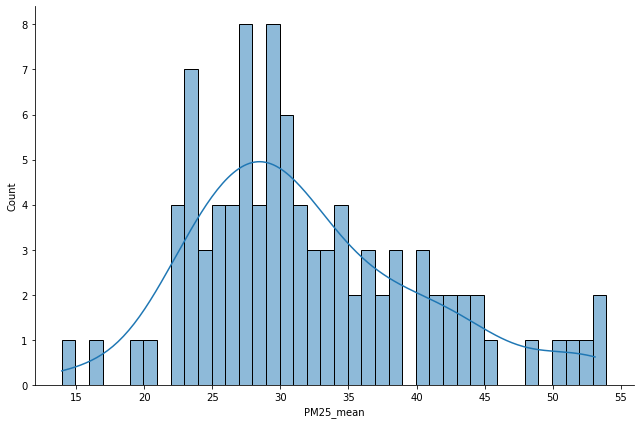

In [184]:
# Have a look at the distribution plot for the mean values
sns.displot(stats_pt, x='PM25_mean', binwidth = 1, kde=True, height=6, aspect=3/2)

### Explore the mean PM2_5 values for each grid and plot this for Utrecht

<AxesSubplot:>

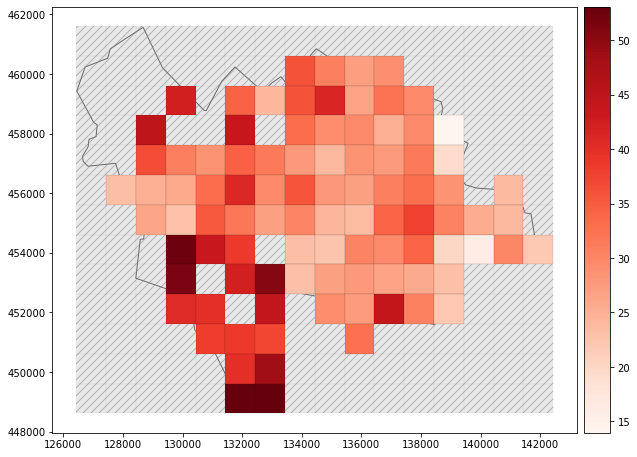

In [185]:
# Merge statistics to original gridfile and plot result
result = pd.merge(grid, stats_pt , on='id', how='outer')

# Plot Utrecht
ax = Utrechtgeo.plot(figsize=(10, 10), color='white', edgecolor='black')

# Make axis dividable so the colorbar equals the figure
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

# Plot the new grid for Utrecht
result.plot(ax=ax, markersize = 1, edgecolor='black', linewidth = 0.1,
            column = 'PM25_mean',
            cmap='Reds',
            legend=True,
            cax=cax,
            missing_kwds={
                "color": "lightgrey",
                "edgecolor": "grey",
                "hatch": "///",
                "label": "Missing values",
                "alpha": 0.5
            },
            #scheme='Quantiles', k=8
           )

# Explore RIVM data

In [355]:
RIVM = pd.read_csv("RIVM_data/UU/2020010310_pm25.txt", sep='\t', low_memory=False)
RIVM

,X,Y,CONC
0,178500,474500,6.1
1,179500,474500,6.2
2,174500,474500,6.0
3,175500,474500,6.0
4,176500,474500,6.1
...,...,...,...
2395,120500,436500,4.7
2396,120500,437500,4.8
2397,121500,435500,4.7
2398,121500,436500,4.7


### Plot the observations and the 1x1 km² grid

(448000.0, 462500.0)

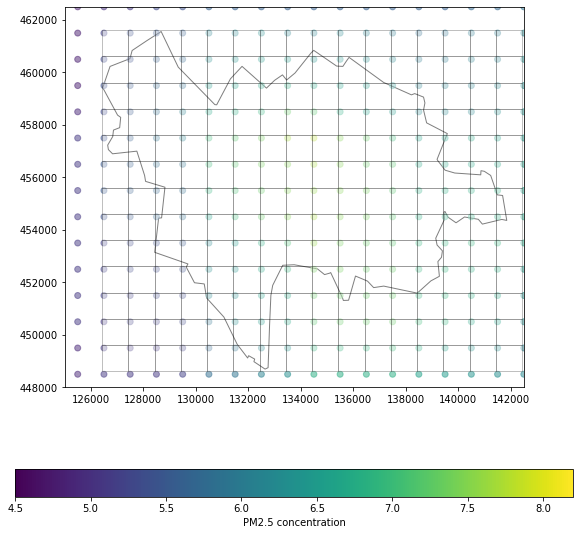

In [356]:
# Create GeoDataFrame from the textfile
RIVM_geo = gpd.GeoDataFrame(RIVM, geometry = gpd.points_from_xy(RIVM['X'], RIVM['Y'], crs="EPSG:28992"))

# Plot Utrecht
ax = Utrechtgeo.plot(figsize=(10, 10), color='white', edgecolor='black')

# Plot RIVM Observations
RIVM_geo.plot(column = 'CONC', alpha=0.5,
              ax=ax, 
              cmap = 'viridis', legend=True,
              legend_kwds={'label': "PM2.5 concentration",
                           'orientation': "horizontal"}
             )

# Plot the 1x1 km² grid for Utrecht
grid.plot(ax=ax, markersize = 1, edgecolor='black', linewidth = 0.5, alpha = 0.5, facecolor = 'white')

plt.xlim([125000, 142500])
plt.ylim([448000, 462500])

### Assign the observations to the grid polygons and plot the grid values as a choropleth map

In [357]:
# Merge the RIVM observations with the grid polygons and remove observations outside of Utrecht
RIVM_geo_utrecht = gpd.sjoin(RIVM_geo, grid, how="left")

# Drop values observations outside the grid (with NaN values)
RIVM_geo_utrecht = RIVM_geo_utrecht[RIVM_geo_utrecht.index_right.notnull()]

# Drop columns that are not of interest
RIVM_grid = RIVM_geo_utrecht.drop(columns=['X', 'Y', 'geometry', 'index_right', 'left', 'top', 'right', 'bottom'])

# Merge statistics to original gridfile
RIVM_result = pd.merge(grid, RIVM_grid , on='id', how='inner')

<AxesSubplot:>

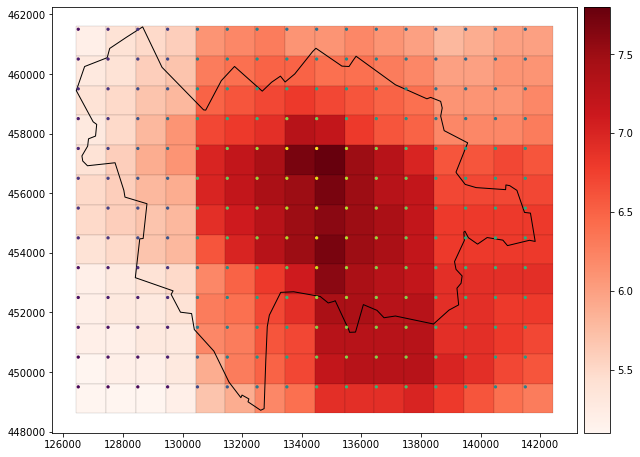

In [358]:
# Create a figure
fig, ax = plt.subplots(figsize=(10, 10))

# Make axis dividable so the colorbar equals the figure
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

# Plot the new grid for Utrecht
RIVM_result.plot(ax=ax, markersize = 1, edgecolor='black',
                 linewidth = 0.1,
                 column = 'CONC',
                 cmap='Reds',
                 legend=True,
                 cax=cax,
                 alpha=1
                )

# Plot Utrecht
Utrechtgeo.plot(figsize=(10, 10), facecolor = 'none', edgecolor='black', ax=ax)

# Plot RIVM observations
RIVM_geo_utrecht.plot(ax=ax, 
                      column = 'CONC',
                      s = 5)

### Read multiple text files for a day and merge into one dataframe

In [176]:
# Read multiple CSV files and merge into one dataframe [2020.01.06.06 - 2020.01.06.20]

# Assign path
RIVM_path = r'RIVM_data/UU'

# specify the day for analysis
day = '22'

# Assign wildcards to read between the 6th hour and the 20th hour of a specific day
RIVM_files_0_9 = glob.glob(RIVM_path + "/202001%s0*[6-9]_pm25.txt" % (day))
RIVM_files_10_19 = glob.glob(RIVM_path + "/202001%s1*[0-9]_pm25.txt" % (day))
RIVM_files_20_23 = glob.glob(RIVM_path + "/202001%s20_pm25.txt" % (day))

RIVM_files = RIVM_files_0_9 + RIVM_files_10_19 + RIVM_files_20_23

li = []

for filename in RIVM_files:
    df = pd.read_csv(filename, index_col=None, header=0, sep='\t', low_memory=False)
    li.append(df)

RIVM_day = pd.concat(li, axis=0, ignore_index=True)
RIVM_day.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36000 entries, 0 to 35999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       36000 non-null  int64  
 1   Y       36000 non-null  int64  
 2   CONC    36000 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 843.9 KB


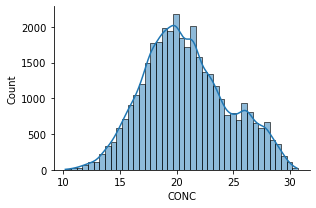

In [177]:
# Have a look at the distribution of PM25 values
sns.displot(RIVM_day, x='CONC', binwidth = 0.5, kde=True, height=3, aspect=3/2)

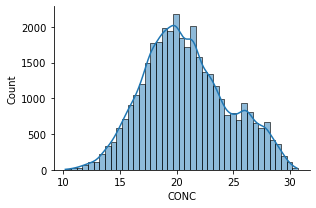

In [178]:
# Drop values < 0
RIVM_day = RIVM_day[RIVM_day['CONC'] >= 0]

sns.displot(RIVM_day, x='CONC', binwidth = 0.5, kde=True, height=3, aspect=3/2)

In [179]:
# Create GeoDataFrame from the textfile
RIVM_geo_day = gpd.GeoDataFrame(RIVM_day, geometry = gpd.points_from_xy(RIVM_day['X'], RIVM_day['Y'], crs="EPSG:28992"))

# Merge the RIVM observations with the grid polygons and remove observations outside of Utrecht
RIVM_geo_day = gpd.sjoin(RIVM_geo_day, grid, how="left")

# Drop values observations outside the grid (with NaN values)
RIVM_geo_day = RIVM_geo_day[RIVM_geo_day.index_right.notnull()]
RIVM_geo_day.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 3120 entries, 932 to 35315
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   X            3120 non-null   int64   
 1   Y            3120 non-null   int64   
 2   CONC         3120 non-null   float64 
 3   geometry     3120 non-null   geometry
 4   index_right  3120 non-null   float64 
 5   id           3120 non-null   float64 
 6   left         3120 non-null   float64 
 7   top          3120 non-null   float64 
 8   right        3120 non-null   float64 
 9   bottom       3120 non-null   float64 
dtypes: float64(7), geometry(1), int64(2)
memory usage: 268.1 KB


In [180]:
# Generate statistics from the RIVM observations
stats_rivm  = RIVM_geo_day.groupby('id').agg(
    PM25_mean = ('CONC','mean'),
    PM25_std  = ('CONC','std'),
    PM25_max  = ('CONC','max'),
    PM25_min  = ('CONC','min'),
    PM25_count =('CONC', 'count')
)
stats_rivm

# Merge statistics to original gridfile
RIVM_result_day = pd.merge(grid, stats_rivm , on='id', how='inner')
RIVM_result_day

,id,left,top,right,bottom,geometry,PM25_mean,PM25_std,PM25_max,PM25_min,PM25_count
0,1.0,126434.772,461609.608,127434.772,460609.608,"POLYGON ((126434.772 461609.608, 127434.772 46...",21.433333,1.722816,24.5,19.0,15
1,2.0,126434.772,460609.608,127434.772,459609.608,"POLYGON ((126434.772 460609.608, 127434.772 46...",21.746667,1.740635,24.8,19.4,15
2,3.0,126434.772,459609.608,127434.772,458609.608,"POLYGON ((126434.772 459609.608, 127434.772 45...",21.933333,1.752413,25.0,19.7,15
3,4.0,126434.772,458609.608,127434.772,457609.608,"POLYGON ((126434.772 458609.608, 127434.772 45...",21.980000,1.793719,25.1,19.7,15
4,5.0,126434.772,457609.608,127434.772,456609.608,"POLYGON ((126434.772 457609.608, 127434.772 45...",22.553333,1.949310,25.6,19.7,15
...,...,...,...,...,...,...,...,...,...,...,...
203,204.0,141434.772,453609.608,142434.772,452609.608,"POLYGON ((141434.772 453609.608, 142434.772 45...",23.840000,2.410335,27.0,19.9,15
204,205.0,141434.772,452609.608,142434.772,451609.608,"POLYGON ((141434.772 452609.608, 142434.772 45...",23.840000,2.467735,27.1,19.8,15
205,206.0,141434.772,451609.608,142434.772,450609.608,"POLYGON ((141434.772 451609.608, 142434.772 45...",23.760000,2.540472,27.1,19.5,15
206,207.0,141434.772,450609.608,142434.772,449609.608,"POLYGON ((141434.772 450609.608, 142434.772 45...",23.540000,2.591139,26.9,19.1,15


<AxesSubplot:>

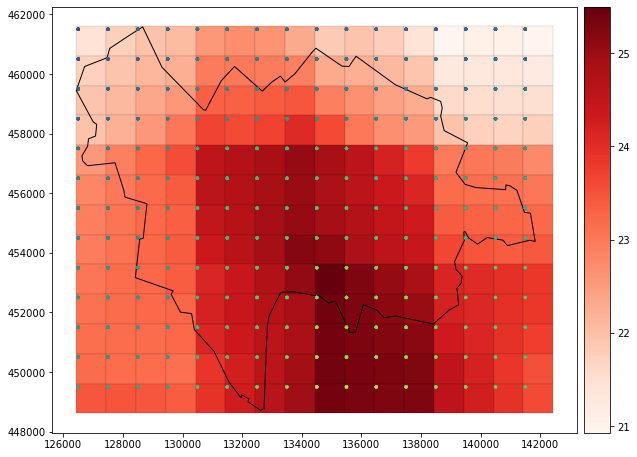

In [181]:
# Create a figure to plot the results in the grid
fig, ax = plt.subplots(figsize=(10, 10))

# Make axis dividable so the colorbar equals the figure
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

# Plot the new grid for Utrecht
RIVM_result_day.plot(ax=ax, markersize = 1, edgecolor='black',
                 linewidth = 0.1,
                 column = 'PM25_mean',
                 cmap='Reds',
                 legend=True,
                 cax=cax
                )

# Plot Utrecht
Utrechtgeo.plot(figsize=(10, 10), facecolor = 'none', edgecolor='black', ax=ax)

# Plot RIVM observations
RIVM_geo_day.plot(ax=ax, 
                      column = 'CONC',
                      s = 5)

#

# Compare sniffing bike observations to RIVM measurements

1) Create a 25 x 25 m grid (or read one with a created one from QGIS) 
2) Average the measurements within a grid cell
2) Read observations from RIVM and average them for the stations
3) Compare averaged station values with rasterized sniffing bike values
4) Delete observations that are to different from official measurements

TESTCODE

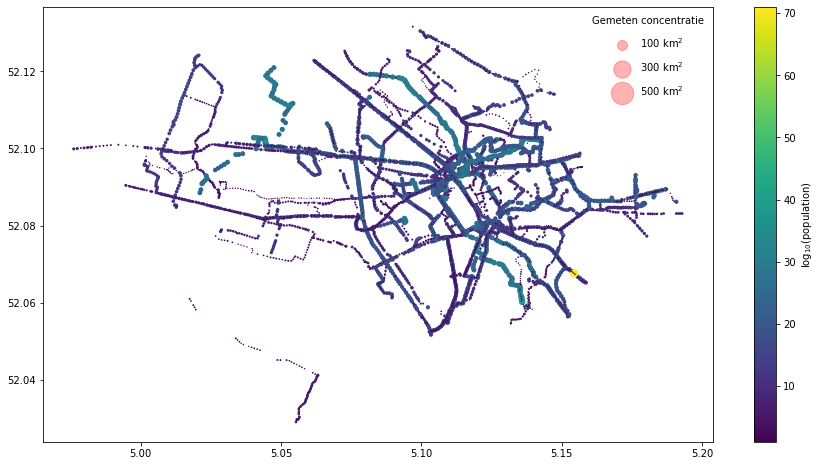

In [56]:
lat, lon = Smallcount['lat'], Smallcount['lon']
plt.figure(figsize=(15, 8))
plt.scatter(lon, lat, label=None, c = Smallcount['pm2_5'], linewidth=0, s = Smallcount['pm2_5'])
plt.colorbar(label='log$_{10}$(population)')

# Create a legend
for area in [100, 300, 500]:
    plt.scatter([], [], color='r', alpha=0.3, s=area,
                label=str(area) + ' km$^2$')
plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title='Gemeten concentratie')